### libs and defs

In [218]:
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf

# Load the S-parameter file
bjt = rf.Network('Sparam-partI.s2p', )

# Filter for 4 GHz
freq_idx = rf.util.find_nearest_index(bjt.f, 4e9)
freq_point = bjt[freq_idx]

# Define a function to calculate the square of the absolute value
def sqabs(x): return np.square(np.absolute(x))



### Bias

In [2]:
from sympy import * 
r1, r2,r3,r4,b,vbe,vce,vcc,ib,ic,ie = symbols('R_1 R_2 R_3 R_4 beta V_{BE} V_{CE} V_{CC} I_b I_C I_E')


r2  = 1e3
r4  = 100
vcc = 10
b   = 72.534
ic  = 9e-3
vbe = 1
vce = 5

ib  = ic/b
ie  = (b+1)*ib
eq1 = vcc - r3*ic-r4*ie-vce
vth = vcc*( r2/(r1+r2) )
rth = (r1*r2)/(r1+r2)
eq2 = -vth + ib*rth+vbe+ie*r4

s = solve( [eq1,eq2],[r1,r3] )
pprint(s)

{R₁: 3971.3433878574, R₃: 454.17689175651}


### Stability

MAG at 4 GHz: 26.126384151655394


/var/folders/q2/6c9pq0ld17dcrdxrph5h7gd00000gn/T/ipykernel_58702/3788656461.py:13: RuntimeWarning: invalid value encountered in sqrt
  MAG = np.abs(bjt.s12.s/bjt.s21.s) * (k-np.sqrt(np.square(k)-1))


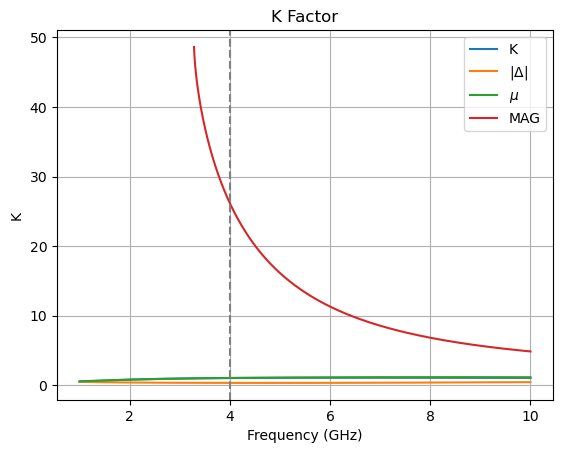

In [219]:
# delta is the determinant of the S-parameter matrix
delta = bjt.s11.s * bjt.s22.s - bjt.s12.s * bjt.s21.s

# k calculation
k = (1 - sqabs(bjt.s11.s) - sqabs(bjt.s22.s) + sqabs(delta)) / \
    (2 * np.abs(bjt.s12.s * bjt.s21.s))

# mu calculation
mu = (1 - sqabs(bjt.s11.s)) / (np.abs(bjt.s22.s -
                                      (delta*np.conj(bjt.s11.s)))+np.abs(bjt.s21.s*bjt.s12.s))

# Maximum available gain (MAG) calculation
MAG = np.abs(bjt.s12.s/bjt.s21.s) * (k-np.sqrt(np.square(k)-1))

k = np.squeeze(k)  # Remove any singleton dimensions
delta = np.squeeze(delta)  # Remove any singleton dimensions
mu = np.squeeze(mu)  # Remove any singleton dimensions
MAG = np.squeeze(MAG)  # Remove any singleton dimensions

# Print MAG at 4 Ghz
val = MAG[freq_idx]
print('MAG at 4 GHz:', val)

# Plotting k values
plt.figure()
plt.plot(bjt.f/1e9, k)
plt.plot(bjt.f/1e9, np.abs(delta))
plt.plot(bjt.f/1e9, mu)
plt.plot(bjt.f/1e9, MAG)
#add line in 4 Ghz
plt.axvline(x=4, color='gray', linestyle='--')
plt.title('K Factor')
plt.xlabel('Frequency (GHz)')
plt.ylabel('K')
plt.grid()
plt.legend(['K', '|$\\Delta$|', '$\\mu$', 'MAG'])
plt.show()


### Calc $\rho_L$ and $\rho_S$ and $\Z_L$ and $\Z_S$

In [220]:
# Calcular B1, B2, C1 e C2
print("Frequency (GHz):", bjt.f[freq_idx] / 1e9)
delta4GHz = delta[freq_idx]
print('delta4GHz:', delta4GHz)

# S11 and S22 for 4 GHz
s11 = freq_point.s11.s[0, 0]  
s22 = freq_point.s22.s[0, 0]  
print('S11:', s11)
print('S22:', s22)
print('|s11|: ', np.abs(s11))
print('|s22|: ', np.abs(s22))

B1 = 1 + sqabs(s11) - sqabs(s22) - sqabs(delta4GHz)
print('B1:', B1)
B2 = 1 + sqabs(s22) - sqabs(s11) - sqabs(delta4GHz)
print('B2:', B2)
C1 = s11 - (delta4GHz * np.conj(s22))
print('C1:', C1)
C2 = s22 - (delta4GHz * np.conj(s11))
print('C2:', C2)

# Calcular ros (ρs) e rol (ρL)
ros = (B1 - np.sqrt(np.square(B1) - 4 * sqabs(C1))) / (2 * C1)
rol = (B2 - np.sqrt(np.square(B2) - 4 * sqabs(C2))) / (2 * C2)
print("ros (ρs):", ros)
print("rol (ρL):", rol)
zs = (1 + ros) / (1 - ros)
zl = (1 + rol) / (1 - rol)
print("zs:", zs)
print("zl:", zl)

Frequency (GHz): 4.00311072181212
delta4GHz: (-0.03435616234300311-0.34612226701384374j)
S11: [-0.33990673+0.27537675j]
S22: [0.06042986-0.17647029j]
|s11|:  [0.43745736]
|s22|:  [0.18653024]
B1: [1.03559444]
B2: [0.72244362]
C1: [-0.39891088+0.30235572j]
C2: [0.144066-0.30358047j]
ros (ρs): [-0.61339711-0.4649262j]
rol (ρL): [0.29177619+0.6148401j]
zs: [0.14457529-0.32982769j]
zl: [0.6103145+1.39798452j]


### Calc matching source and load circuit with Lumped elements in L

In [221]:

def calc_lumped_matching_circuits(f, z0, rl, xl):
    zl = rl + 1j*xl
    zl = np.conj(zl)
    rl = np.real(zl)
    xl = np.imag(zl)
    if rl > 1: 
        b1 = (xl + (np.sqrt(rl/z0)*np.sqrt(np.square(rl)+np.square(xl)-z0*rl)))/(np.square(rl)+np.square(xl))
        b2 = (xl - (np.sqrt(rl/z0)*np.sqrt(np.square(rl)+np.square(xl)-z0*rl)))/(np.square(rl)+np.square(xl))

        xa = 1/b1 + (xl*z0/rl) - (z0/(b1*rl))
        x1 = xa
        x2 = - xa

        if b1 > 0:
            bmais = b1
            bmenos = b2
        else:
            bmais = b2
            bmenos = b1
        if x1 > 0:
            xmais = x1
            xmenos = x2
        else:
            xmais = x2
            xmenos = x1
        print("------------------------------------")
        print("Z0 - Xserie + Bparalelo - Z")
        print("B+ = ", bmais)
        print("X+ = ", xmais)
        print("B- = ", bmenos)
        print("X- = ", xmenos)
        print("------------------------------------")
        z0 = 50
        L_serie = xmais*z0/(2*np.pi*f)
        C_paralelo = bmais/(2*np.pi*f*z0)
        L_paralelo = -z0/(bmenos*2*np.pi*f)
        C_serie = -1/(z0*xmenos*2*np.pi*f)
        print("L_serie = ", L_serie)
        print("C_paralelo = ", C_paralelo)
        print("L_paralelo = ", L_paralelo)
        print("C_serie = ", C_serie)
        print("------------------------------------")
    else:
        xa = np.sqrt(rl*(z0-rl))
        if (xl<0):
            xmenos = -np.abs(xa - xl)
            xmais = np.abs(-xa - xl)
        else:
            xmenos = -xa - xl
            xmais = xa - xl

        ba = np.sqrt((z0-rl)/rl)/z0
        bmais = ba
        bmenos = -ba

        print("------------------------------------")
        print("Z0 - Bparalelo + Xserie - Z")
        print("X+ = ", xmais)
        print("X- = ", xmenos)
        print("B+ = ", bmais)
        print("B- = ", bmenos)
        print("------------------------------------")
        z0 = 50
        L_serie = xmais*z0/(2*np.pi*f)
        C_paralelo = bmais/(2*np.pi*f*z0)
        L_paralelo = -z0/(bmenos*2*np.pi*f)
        C_serie = -1/(z0*xmenos*2*np.pi*f)
        print("L_serie = ", L_serie)
        print("C_paralelo = ", C_paralelo)
        print("L_paralelo = ", L_paralelo)
        print("C_serie = ", C_serie)
        print("------------------------------------")
    return


f = freq_point.f[0]  
rs = np.real(zs)
xs = np.imag(zs)
rl = np.real(zl)
xl = np.imag(zl)
z0 = 1

print("------------------------------------")
print("Calc source matching circuit")
calc_lumped_matching_circuits(f, z0, rs, xs)
print("------------------------------------")
print("Calc load matching circuit")
calc_lumped_matching_circuits(f, z0, rl, xl)

------------------------------------
Calc source matching circuit
------------------------------------
Z0 - Bparalelo + Xserie - Z
X+ =  [0.02184442]
X- =  [-0.68149981]
B+ =  [2.43244964]
B- =  [-2.43244964]
------------------------------------
L_serie =  [4.34243305e-11]
C_paralelo =  [1.93417775e-12]
L_paralelo =  [8.17238232e-10]
C_serie =  [1.16677412e-12]
------------------------------------
------------------------------------
Calc load matching circuit
------------------------------------
Z0 - Bparalelo + Xserie - Z
X+ =  [0.91030562]
X- =  [-1.88566342]
B+ =  [0.79906164]
B- =  [-0.79906164]
------------------------------------
L_serie =  [1.8095882e-09]
C_paralelo =  [6.35378928e-13]
L_paralelo =  [2.4877816e-09]
C_serie =  [4.2168519e-13]
------------------------------------


### Calc impedance matching with lines and stubs

In [223]:
def calc_lines_stubs_circuit(z0,zl,f):
    #calc admitance
    y0 = 1/z0
    zl = zl*z0
    zl = np.conj(zl)
    rl = np.real(zl)
    xl = np.imag(zl)
    c  = 3e8
    w  = 1.5e-3
    h  = 800e-6
    er = 4
    #shunt stubs
    print("------------------------------------")
    print("Calc shunt stubs")
    print("------------------------------------")
    
    t1 = (xl + np.sqrt(rl*(np.square(z0-rl)+np.square(xl))/z0))/(rl-z0)
    t2 = (xl - np.sqrt(rl*(np.square(z0-rl)+np.square(xl))/z0))/(rl-z0)
    print("t1:", t1)
    print("t2:", t2)

    e_eff = (er +1)/2 + ((er-1)/2)*(1+12*(h/w))**(-1/2)
    v_real = c/np.sqrt(e_eff)
    lbd = v_real / f

    t = t1
    # G1 = (rl*(1+np.square(t)))/(np.square(rl)+np.square(xl + z0*t))
    # print("G1:", G1)
    B1 = (np.square(rl)*t - (z0-xl*t)*(xl+z0*t))/(z0*(np.square(rl)+np.square(xl+z0*t)))
    print("B1:", B1)
    if t >= 0:
        d = ((1/(2*np.pi)*np.arctan(t)))
        if d < 0:
            d_lt = d/f + 1/(2*f)
            d_can = (d+1/2) * lbd
        else:
            d_lt = d/f
            d_can = d * lbd
        print("d1_lt:", d_lt)
        print("d1_cadence:", d_can[0]*1e3)
    else:
        d = (1/(2*np.pi)*(np.pi * np.arctan(t)))
        if d < 0:
            d_lt = d/f + 1/(2*f)
            d_can = (d+1/2) * lbd
        else:
            d_lt = d/f
            d_can = d * lbd
        print("d1_lt:", d_lt)
        print("d1_cadence:", d_can[0]*1e3)

    t = t2
    # G2 = (rl*(1+np.square(t)))/(np.square(rl)+np.square(xl + z0*t))
    # print("G2:", G2)
    B2 = (np.square(rl)*t - (z0-xl*t)*(xl+z0*t))/(z0*(np.square(rl)+np.square(xl+z0*t)))
    print("B2:", B2)
    if t >= 0:
        d = ((1/(2*np.pi)*np.arctan(t)))
        if d < 0:
            d_lt = d/f + 1/(2*f)
            d_can = (d+1/2) * lbd
        else:
            d_lt = d/f
            d_can = d * lbd
        print("d2_lt:", d_lt)
        print("d2_cadence:", d_can[0]*1e3)
    else:
        d = (1/(2*np.pi)*(np.pi * np.arctan(t)))
        if d < 0:
            d_lt = d/f + 1/(2*f)
            d_can = (d+1/2) * lbd
        else:
            d_lt = d/f
            d_can = d * lbd
        print("d2_lt:", d_lt)
        print("d2_cadence:", d_can[0]*1e3)
    
    #open circuit
    print(">>>>>>> Open circuit")
    l1 = (-1/(2*np.pi)*np.arctan(B1/y0))
    if l1 < 0:
        l1_lt = l1/f + 1/(2*f)
        l1_can = l1 * lbd
    else:
        l1_lt = l1/f
        l1_can = l1*lbd
    print("l1_tl:", l1_lt)
    print("l1_can:", l1_can[0]*1e3)
    l2 = (-1/(2*np.pi)*np.arctan(B2/y0))
    if l2 < 0:
        l2_lt = l2/f + 1/(2*f)
        l2_can = l2 * lbd
    else:
        l2_lt = l2/f
        l2_can = l2*lbd
    print("l2_tl:", l2_lt)
    print("l2_can:", l2_can[0]*1e3)
    #short circuit
    print(">>>>>>> Short circuit")
    l1 = (1/(2*np.pi)*np.arctan(y0/B1))
    if l1 < 0:
        l1_lt = l1/f + 1/(2*f)
        l1_can = l1 * lbd
    else:
        l1_lt = l1/f
        l1_can = l1*lbd
    print("l1_tl:", l1_lt)
    print("l1_can:", l1_can[0]*1e3)
    l2 = (1/(2*np.pi)*np.arctan(y0/B2))
    if l2 < 0:
        l2_lt = l2/f + 1/(2*f)
        l2_can = l2 * lbd
    else:
        l2_lt = l2/f
        l2_can = l2*lbd
    print("l2_tl:", l2_lt)
    print("l2_can:", l2_can[0]*1e3)

    # #series stubs
    # print("------------------------------------")
    # print("Calc series stubs")
    # print("------------------------------------")
    # yl = 1/zl
    # gl = np.real(yl)
    # bl = np.imag(yl)
    
    # t1 = (bl + np.sqrt(gl*((np.square(y0-gl)+np.square(bl)))/y0))/(gl-y0)
    # print("t1:", t1)
    # t2 = (bl - np.sqrt(gl*((np.square(y0-gl)+np.square(bl)))/y0))/(gl-y0)
    # print("t2:", t2)

    # t = t1
    # if t >= 0:
    #     d = (1/(2*np.pi)*np.arctan(t))/f
    #     if d < 0:
    #         d = d + 1/(2*f)
    #     print("d:", d)
    # else:
    #     d = (1/(2*np.pi)*(np.pi * np.arctan(t)))/f
    #     if d < 0:
    #         d = d + 1/(2*f)
    #     print("d:", d)
    # R1 = (gl*(1+np.square(t)))/(np.square(gl)+np.square(bl + y0*t))
    # print("R1:", R1)
    # X1 = (np.square(gl)*t - (y0-bl*t)*(bl+y0*t))/(y0*(np.square(gl)+np.square(bl+y0*t)))
    # print("X1:", X1)

    # t= t2
    # if t >= 0:
    #     d = (1/(2*np.pi)*np.arctan(t))/f
    #     if d < 0:
    #         d = d + 1/(2*f)
    #     print("d:", d)
    # else:
    #     d = (1/(2*np.pi)*(np.pi * np.arctan(t)))/f
    #     if d < 0:
    #         d = d + 1/(2*f)
    #     print("d:", d)
    # R2 = (gl*(1+np.square(t)))/(np.square(gl)+np.square(bl + y0*t))
    # print("R2:", R2)
    # X2 = (np.square(gl)*t - (y0-bl*t)*(bl+y0*t))/(y0*(np.square(gl)+np.square(bl+y0*t)))
    # print("X2:", X2)
    # #short circuit
    # print(">>>>>>> Short circuit")
    # l1 = (-1/(2*np.pi)*np.arctan(X1/z0))/f
    # if l1 < 0:
    #     l1 = l1 + 1/(2*f)
    # print("l1:", l1)
    # l2 = (-1/(2*np.pi)*np.arctan(X2/z0))/f
    # if l2 < 0:
    #     l2 = l2 + 1/(2*f)
    # print("l2:", l2)
    # #open circuit
    # print(">>>>>>> Open circuit")
    # l1 = (1/(2*np.pi)*np.arctan(z0/X1))/f
    # if l1 < 0:
    #     l1 = l1 + 1/(2*f)
    # print("l1:", l1)
    # l2 = (1/(2*np.pi)*np.arctan(z0/X2))/f
    # if l2 < 0:
    #     l2 = l2 + 1/(2*f)
    # print("l2:", l2)

print("------------------------------------")
print("Calc source matching circuit")
calc_lines_stubs_circuit(50,zs,f)
print("\n------------------------------------")
print("Calc loud matching circuit")
calc_lines_stubs_circuit(50,zl,f)


------------------------------------
Calc source matching circuit
------------------------------------
Calc shunt stubs
------------------------------------
t1: [-0.79308709]
t2: [0.02194339]
B1: [0.04822382]
d1_lt: [4.11540555e-11]
d1_cadence: 7.067788452682296
B2: [-0.04822382]
d2_lt: [8.72281171e-13]
d2_cadence: 0.1498053767439912
>>>>>>> Open circuit
l1_tl: [7.80819097e-11]
l1_can: -8.04102066627723
l2_tl: [4.68209558e-11]
l2_can: 8.04102066627723
>>>>>>> Short circuit
l1_tl: [1.5630477e-11]
l1_can: 2.684374681317887
l2_tl: [1.09272389e-10]
l2_can: -2.684374681317888

------------------------------------
Calc loud matching circuit
------------------------------------
Calc shunt stubs
------------------------------------
t1: [0.67799788]
t2: [6.49693937]
B1: [0.03715391]
d1_lt: [2.36879585e-11]
d1_cadence: 4.068164787286057
B2: [-0.03715391]
d2_lt: [5.63796139e-11]
d2_cadence: 9.68262251258096
>>>>>>> Open circuit
l1_tl: [8.20845245e-11]
l1_can: -7.353612472804526
l2_tl: [4.28183409

### Gain circles

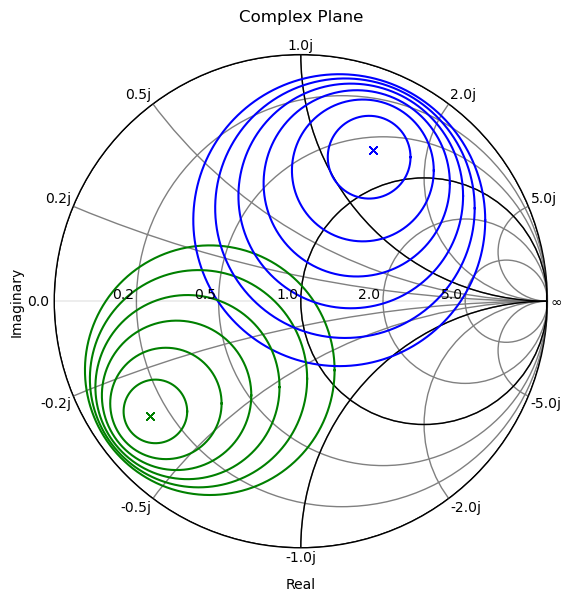

In [226]:
%matplotlib inline

# prepare figure
fig, ax = plt.subplots(1, 1, figsize=(7,8))

# impedance smith chart
rf.plotting.smith(ax = ax, draw_labels = True, chart_type = 'z')

def calc_circle(c, r):
    theta = np.linspace(0, 2*np.pi, 1000)
    return c + r*np.exp(1.0j*theta)

freq_idx = rf.util.find_nearest_index(bjt.f, 4e9)

gmax = val

#gain = 12


#percorer varios valores de ganho
for gain in range(15, 27, 2):

    ga = gain/(np.abs(bjt[freq_idx].s12.s))**2
    cs = (ga*np.conj(C1))/(1+ga*(sqabs(bjt[freq_idx].s11.s) - sqabs(delta4GHz)))
    rs = np.sqrt(1-2*k[freq_idx]*np.abs(bjt[freq_idx].s21.s*bjt[freq_idx].s12.s)*ga + 
                 (ga**2)*np.abs(bjt[freq_idx].s21.s*bjt[freq_idx].s12.s)**2) / np.abs(1+ga*(sqabs(bjt[freq_idx].s11.s) - sqabs(delta4GHz)))

    gp = gain/(np.abs(bjt[freq_idx].s12.s))**2
    cl = (gp*np.conj(C2))/(1+gp*(sqabs(bjt[freq_idx].s22.s) - sqabs(delta4GHz)))
    rl = np.sqrt(1-2*k[freq_idx]*np.abs(bjt[freq_idx].s21.s*bjt[freq_idx].s12.s)*gp + 
                 (gp**2)*np.abs(bjt[freq_idx].s21.s*bjt[freq_idx].s12.s)**2) / np.abs(1+gp*(sqabs(bjt[freq_idx].s22.s) - sqabs(delta4GHz)))

    sgc = calc_circle(cs, rs)
    sgl = calc_circle(cl, rl)
    rf.plotting.plot_smith(s=np.squeeze(sgc), smith_r=1, color = 'green', draw_labels=True)
    rf.plotting.plot_smith(s=np.squeeze(sgl), smith_r=1, color = 'blue', draw_labels=True)

#para ganho maximo raio =0
gain = gmax
ga = gain/(np.abs(bjt[freq_idx].s12.s))**2
cs = (ga*np.conj(C1))/(1+ga*(sqabs(bjt[freq_idx].s11.s) - sqabs(delta4GHz)))
rs = 0

gp = gain/(np.abs(bjt[freq_idx].s12.s))**2
cl = (gp*np.conj(C2))/(1+gp*(sqabs(bjt[freq_idx].s22.s) - sqabs(delta4GHz)))
rl = 0

sgc = calc_circle(cs, rs)
sgl = calc_circle(cl, rl)
rf.plotting.plot_smith(s=np.squeeze(sgc), smith_r=1, color = 'green', draw_labels=True, marker = 'x')
rf.plotting.plot_smith(s=np.squeeze(sgl), smith_r=1, color = 'blue', draw_labels=True, marker ='x')


#ss = rf.z2s(z=np.array([[[(zs.item())*50]]]), z0=50)
#sl = rf.z2s(z=np.array([[[(zl.item())*50]]]), z0=50)
#rf.plotting.plot_smith(s=ss[0][0], smith_r=1, color = 'green', marker = 'x')
#rf.plotting.plot_smith(s=sl[0][0], smith_r=1, color = 'blue', marker = 'x')
